In [30]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers, losses
import seaborn as sns
sns.set_style('whitegrid')

In [31]:
IMG_SIZE = 160
IMAGE_SHAPE = [160,160]

In [32]:
def load_images_from_folder(folderName):
    image_list =[]
    for fileIndex in range(7000):
      img = cv2.imread("../input/landscape-image-colorization/landscape Images/"+folderName+"/"+str(fileIndex)+".jpg")
      if folderName == "color": 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
      else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
      image_list.append(img)
    return image_list
color = np.empty((0,IMG_SIZE,IMG_SIZE,3))
gray = np.empty((0,IMG_SIZE,IMG_SIZE,1))
color  = np.append(color,load_images_from_folder(r"color"),0)
gray  = np.append(gray,load_images_from_folder(r"gray"),0)

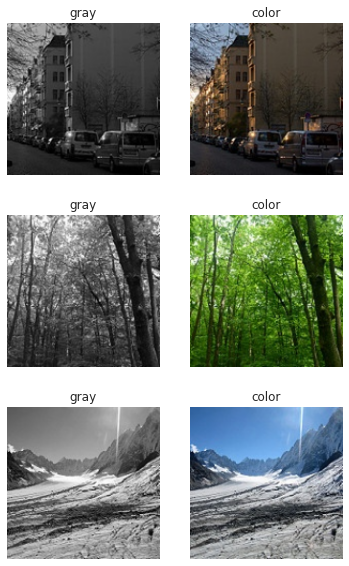

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 10))
for i in range(0,6,2):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(cv2.cvtColor(gray[i].astype('uint8'), cv2.COLOR_BGR2RGB))
  plt.title("gray")
  plt.axis("off")
  ax = plt.subplot(3, 2, i + 2)
  plt.imshow(color[i].astype('uint8'))
  plt.title("color")
  plt.axis("off")

In [34]:
color.shape,gray.shape

((7000, 160, 160, 3), (7000, 160, 160, 1))

In [35]:
color /= 255
gray /= 255

In [36]:
def Colorizer(input_shape):
  encoder_input = keras.Input(shape=input_shape)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(encoder_input)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1)(x)   
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(256, (5, 5), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
    
  encoder_output =  layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(x)

  x = layers.UpSampling2D((2, 2))(encoder_output)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.UpSampling2D((2, 2))(encoder_output)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=1)(x)
  decoder_output = layers.UpSampling2D((2, 2))(x)
  return keras.Model(encoder_input, decoder_output, name="decoder")

colorizer = Colorizer((160,160,1))

In [37]:
colorizer.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 160, 160, 64)      640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 80, 80, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 80, 80, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 40, 128)       147584    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 256)       295168    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 256)       1638

In [38]:
def loss(y_true,y_pred) :
    l = tf.sqrt(tf.reduce_mean(tf.square(tf.abs(y_true - y_pred))))
    return l

In [39]:
# earlystopping = keras.callbacks.EarlyStopping(
#     monitor="accuracy",
#     patience=3,
# )
colorizer.compile(loss=loss, optimizer='adam', metrics=['accuracy','mae','mse'])

In [40]:
# hist = colorizer.fit(gray[:4000], color[:4000],batch_size=32,epochs=100, callbacks = [earlystopping], validation_data = (gray[4001:5000], color[4001:5000]))
hist = colorizer.fit(gray[:6000], color[:6000],batch_size=32,epochs=35,validation_data = (gray[6000:7000], color[6000:7000]))

2022-01-13 05:33:20.093479: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/35
188/188 [==============================] - 22s 106ms/step - loss: 0.1505 - accuracy: 0.3946 - mae: 0.1140 - mse: 0.0248 - val_loss: 0.1205 - val_accuracy: 0.4478 - val_mae: 0.0877 - val_mse: 0.0146
Epoch 2/35
188/188 [==============================] - 18s 94ms/step - loss: 0.1167 - accuracy: 0.4592 - mae: 0.0834 - mse: 0.0137 - val_loss: 0.1111 - val_accuracy: 0.4968 - val_mae: 0.0784 - val_mse: 0.0124
Epoch 3/35
188/188 [==============================] - 18s 94ms/step - loss: 0.1124 - accuracy: 0.4675 - mae: 0.0799 - mse: 0.0127 - val_loss: 0.1106 - val_accuracy: 0.4985 - val_mae: 0.0776 - val_mse: 0.0123
Epoch 4/35
188/188 [==============================] - 18s 94ms/step - loss: 0.1103 - accuracy: 0.4732 - mae: 0.0784 - mse: 0.0122 - val_loss: 0.1068 - val_accuracy: 0.4999 - val_mae: 0.0753 - val_mse: 0.0115
Epoch 5/35
188/188 [==============================] - 18s 94ms/step - loss: 0.1087 - accuracy: 0.4812 - mae: 0.0771 - mse: 0.0119 - val_loss: 0.1059 - val_accuracy: 0.

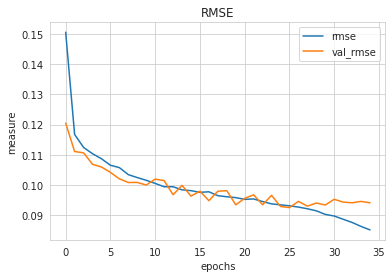

In [41]:
ax = plt.subplot(label= True)
plt.plot(hist.history["loss"], label = "rmse")
plt.plot(hist.history["val_loss"], label = "val_rmse")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('RMSE')
plt.legend(["rmse", "val_rmse"])

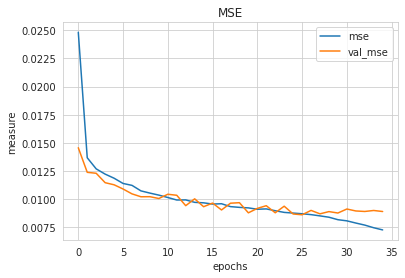

In [42]:
ax = plt.subplot(label= True)
plt.plot(hist.history["mse"], label = "mse")
plt.plot(hist.history["val_mse"], label = "val_mse")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('MSE')
plt.legend(["mse", "val_mse"])

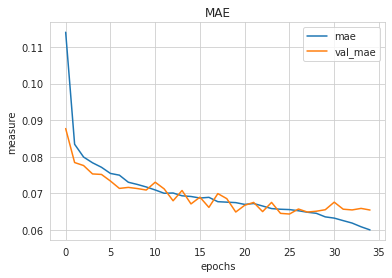

In [43]:
ax = plt.subplot(label= True)
plt.plot(hist.history["mae"], label = "mae")
plt.plot(hist.history["val_mae"], label = "val_mae")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('MAE')
plt.legend(["mae", "val_mae"])

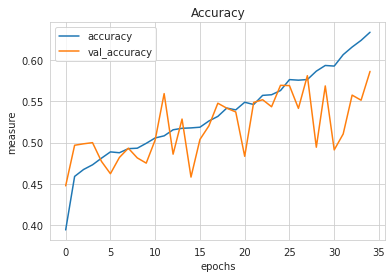

In [44]:
ax = plt.subplot(label= True)
plt.plot(hist.history["accuracy"], label = "accuracy")
plt.plot(hist.history["val_accuracy"], label = "val_accuracy")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('Accuracy')
plt.legend(["accuracy", "val_accuracy"])

In [45]:
colorized_deneme = colorizer.predict(gray[0:1000])

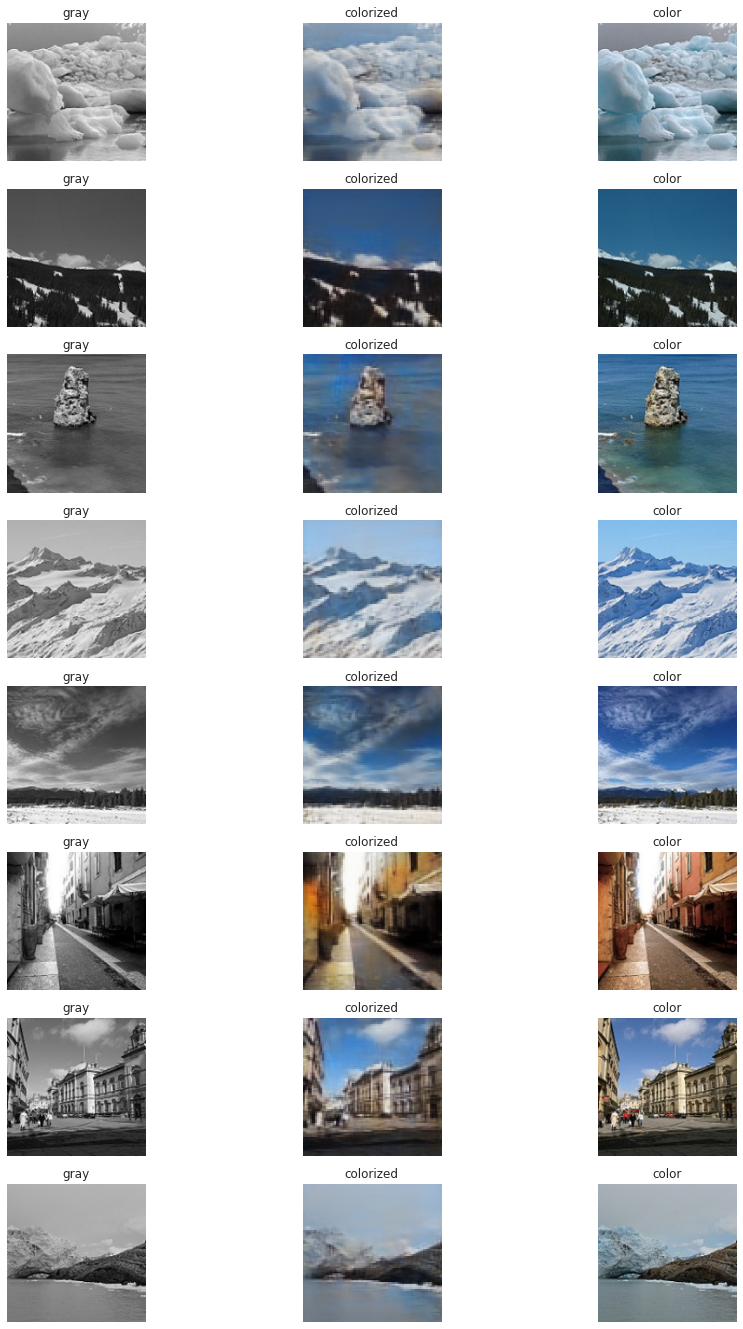

In [46]:
plt.figure(figsize=(15,30))
for i in range(6,30,3):
  ax = plt.subplot(10, 3, i + 1)
  plt.imshow(cv2.cvtColor(gray[0+i].astype("float32"), cv2.COLOR_BGR2RGB))
  plt.title("gray")
  plt.axis('off')
  ax = plt.subplot(10, 3, i + 2)
  plt.imshow(colorized_deneme[i])
  plt.title("colorized")
  plt.axis('off')
  ax = plt.subplot(10, 3, i + 3)
  plt.imshow(color[0+i])
  plt.title("color")
  plt.axis('off')

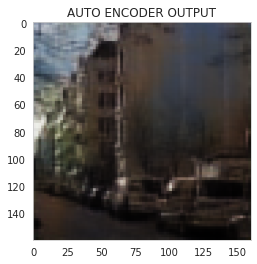

In [47]:
# plt.figure(figsize=(5,5))
plt.imshow(colorized_deneme[0])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

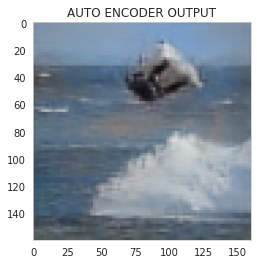

In [48]:
plt.imshow(colorized_deneme[64])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

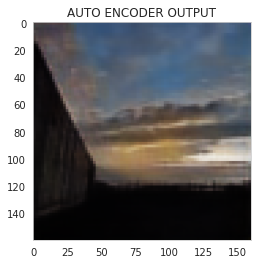

In [49]:
plt.imshow(colorized_deneme[320])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

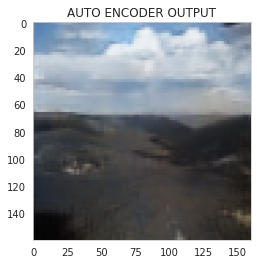

In [50]:
plt.imshow(colorized_deneme[448])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

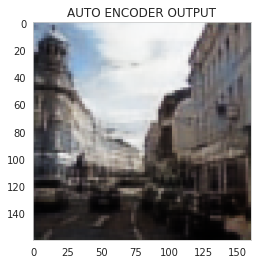

In [51]:
plt.imshow(colorized_deneme[640])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

# AE with conv2D transpose

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
IMG_SIZE = 160
IMAGE_SHAPE = [160,160]

In [4]:
def load_images_from_folder(folderName):
    image_list =[]
    for fileIndex in range(7000):
      img = cv2.imread("../input/landscape-image-colorization/landscape Images/"+folderName+"/"+str(fileIndex)+".jpg")
      if folderName == "color": 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
      else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
      image_list.append(img)
    return image_list
color = np.empty((0,IMG_SIZE,IMG_SIZE,3))
gray = np.empty((0,IMG_SIZE,IMG_SIZE,1))
color  = np.append(color,load_images_from_folder(r"color"),0)
gray  = np.append(gray,load_images_from_folder(r"gray"),0)

In [5]:
color /= 255
gray /= 255

In [6]:
def model() :
    inp = tf.keras.layers.Input(shape=(160,160,1))
    conv1 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu') (inp)
    conv1 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu') (conv1)
    conv2 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu') (conv1)
    conv3 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu') (conv2)
    conv4 = tf.keras.layers.Conv2D(256,3,padding='same',activation='relu') (conv3)
    conv5 = tf.keras.layers.Conv2D(256,3,padding='same',activation='relu') (conv4)
    
    convt1 = tf.keras.layers.Conv2DTranspose(256,3,padding='same',activation='relu') (conv5)
    convt2 = tf.keras.layers.Conv2DTranspose(256,3,padding='same',activation='relu') (convt1)
    convt3 = tf.keras.layers.Conv2DTranspose(128,3,padding='same',activation='relu') (convt2)
    convt4 = tf.keras.layers.Conv2DTranspose(128,3,padding='same',activation='relu') (convt3)
    convt5 = tf.keras.layers.Conv2DTranspose(64,3,padding='same',activation='relu') (convt4)
    convt5 = tf.keras.layers.Conv2DTranspose(64,3,padding='same',activation='relu') (convt5)
    out = tf.keras.layers.Conv2DTranspose(3,3,padding='same',activation='sigmoid') (convt5)
    
    model = tf.keras.models.Model(inp,out)
    model.summary()
    return model

model = model()

2022-01-13 04:07:48.446697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 160, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 160, 128)     147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 160, 160, 256)     295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 160, 160, 256)     590080

2022-01-13 04:07:48.529134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 04:07:48.529779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 04:07:48.530827: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-13 04:07:48.531942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [7]:
def loss(y_true,y_pred) :
    l = tf.sqrt(tf.reduce_mean(tf.square(tf.abs(y_true - y_pred))))
    return l

In [8]:
model.compile(loss=loss, optimizer='adam', metrics=['accuracy','mae','mse'])

In [9]:
hist = model.fit(gray[:5000],color[:5000],batch_size=32,epochs=35,validation_data = (gray[5000:6000], color[5000:6000]))

2022-01-13 04:07:56.978265: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 512000000 exceeds 10% of free system memory.
2022-01-13 04:07:58.076763: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1536000000 exceeds 10% of free system memory.
2022-01-13 04:07:59.662106: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 512000000 exceeds 10% of free system memory.
2022-01-13 04:08:00.032766: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1536000000 exceeds 10% of free system memory.
2022-01-13 04:08:01.197491: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/35


2022-01-13 04:08:03.142074: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 155s 892ms/step - loss: 0.1328 - accuracy: 0.4074 - mae: 0.1006 - mse: 0.0205 - val_loss: 0.0949 - val_accuracy: 0.4451 - val_mae: 0.0671 - val_mse: 0.0091
Epoch 2/35
157/157 [==============================] - 135s 863ms/step - loss: 0.0865 - accuracy: 0.4545 - mae: 0.0604 - mse: 0.0076 - val_loss: 0.0888 - val_accuracy: 0.4389 - val_mae: 0.0620 - val_mse: 0.0080
Epoch 3/35
157/157 [==============================] - 136s 864ms/step - loss: 0.0814 - accuracy: 0.4527 - mae: 0.0554 - mse: 0.0067 - val_loss: 0.0829 - val_accuracy: 0.4493 - val_mae: 0.0556 - val_mse: 0.0070
Epoch 4/35
157/157 [==============================] - 135s 863ms/step - loss: 0.0802 - accuracy: 0.4584 - mae: 0.0543 - mse: 0.0065 - val_loss: 0.0813 - val_accuracy: 0.4364 - val_mae: 0.0540 - val_mse: 0.0067
Epoch 5/35
157/157 [==============================] - 135s 863ms/step - loss: 0.0789 - accuracy: 0.4647 - mae: 0.0530 - mse: 0.0063 - val_loss: 0.0837 - val_accuracy: 0.46

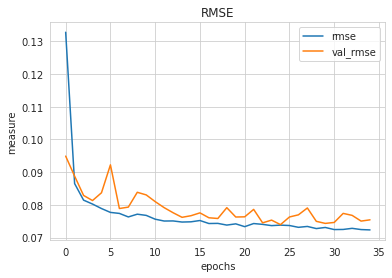

In [10]:
ax = plt.subplot(label= True)
plt.plot(hist.history["loss"], label = "rmse")
plt.plot(hist.history["val_loss"], label = "val_rmse")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('RMSE')
plt.legend(["rmse", "val_rmse"])

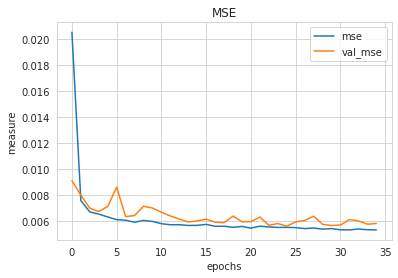

In [11]:
ax = plt.subplot(label= True)
plt.plot(hist.history["mse"], label = "mse")
plt.plot(hist.history["val_mse"], label = "val_mse")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('MSE')
plt.legend(["mse", "val_mse"])

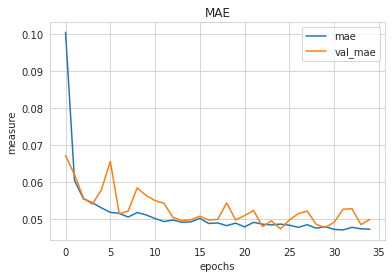

In [12]:
ax = plt.subplot(label= True)
plt.plot(hist.history["mae"], label = "mae")
plt.plot(hist.history["val_mae"], label = "val_mae")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('MAE')
plt.legend(["mae", "val_mae"])

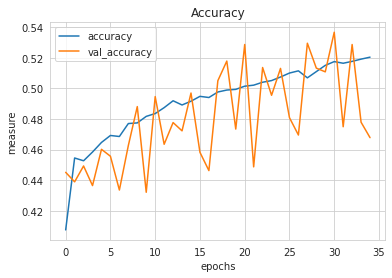

In [13]:
ax = plt.subplot(label= True)
plt.plot(hist.history["accuracy"], label = "accuracy")
plt.plot(hist.history["val_accuracy"], label = "val_accuracy")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('Accuracy')
plt.legend(["accuracy", "val_accuracy"])

In [14]:
colorized_deneme = model.predict(gray[0:1000])

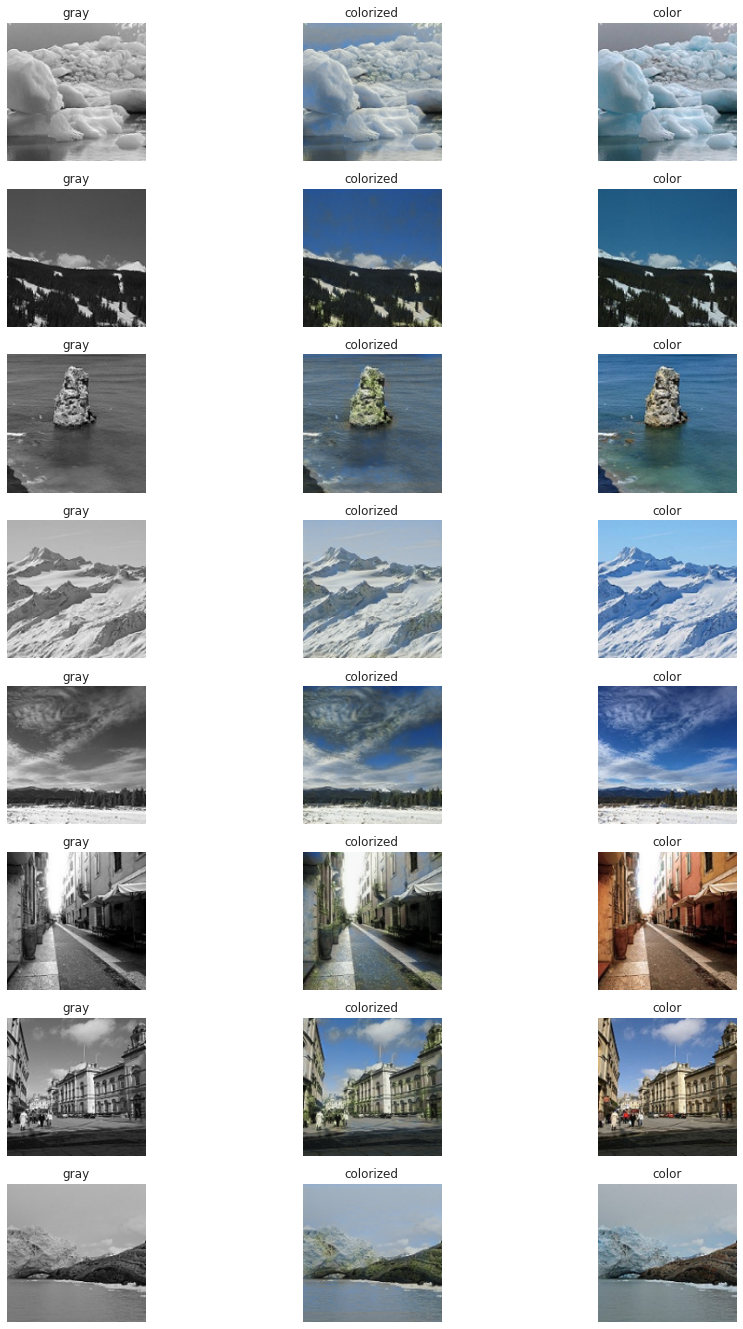

In [15]:
plt.figure(figsize=(15,30))
for i in range(6,30,3):
  ax = plt.subplot(10, 3, i + 1)
  plt.imshow(cv2.cvtColor(gray[0+i].astype("float32"), cv2.COLOR_BGR2RGB))
  plt.title("gray")
  plt.axis('off')
  ax = plt.subplot(10, 3, i + 2)
  plt.imshow(colorized_deneme[i])
  plt.title("colorized")
  plt.axis('off')
  ax = plt.subplot(10, 3, i + 3)
  plt.imshow(color[0+i])
  plt.title("color")
  plt.axis('off')

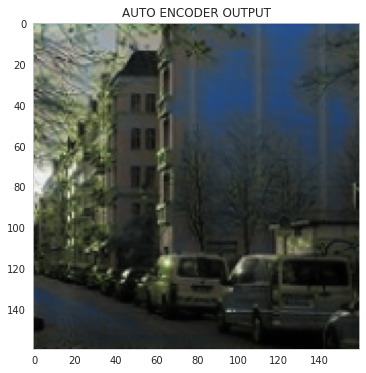

In [25]:
plt.figure(figsize=(6,6))
plt.imshow(colorized_deneme[0])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

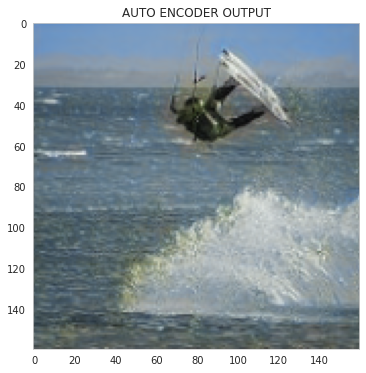

In [26]:
plt.figure(figsize=(6,6))
plt.imshow(colorized_deneme[64])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

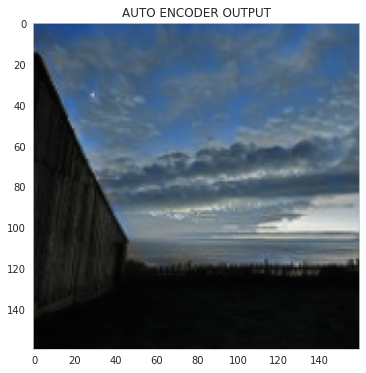

In [27]:
plt.figure(figsize=(6,6))
plt.imshow(colorized_deneme[320])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

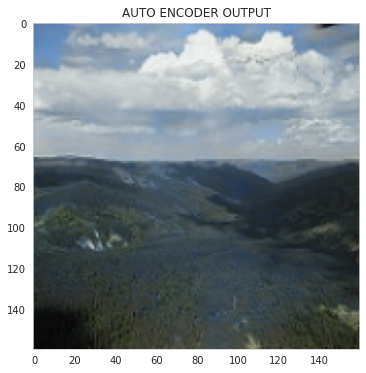

In [28]:
plt.figure(figsize=(6,6))
plt.imshow(colorized_deneme[448])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

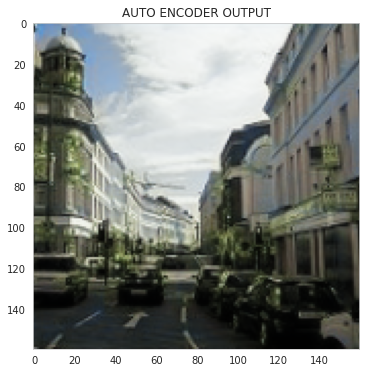

In [29]:
plt.figure(figsize=(6,6))
plt.imshow(colorized_deneme[640])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)